In [1]:
# %%
# for gridsearch

#!pip install pyyaml==5.4.1

# %%
from IPython import get_ipython  # type: ignore

# %% 
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


# %%

from dotmap import DotMap
import json
import os

import numpy as np

# Import the PyTorch modules
import torch  # type: ignore
from torch import nn  # type: ignore
from torch.optim import SGD, Adam, RMSprop, AdamW  # type: ignore

# Import Tensorflow writer
from torch.utils.tensorboard import SummaryWriter  # type: ignore

# Import modules from XTransformers
#from x_transformers.x_transformers import AttentionLayers, Encoder, ContinuousTransformerWrapper
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup

# Import the giotto-deep modules
from gdeep.data import OrbitsGenerator, DataLoaderKwargs
from gdeep.topology_layers import SetTransformer, PersFormer, SetTransformerOld
#from gdeep.topology_layers import AttentionPooling
from gdeep.topology_layers import ISAB, PMA, SAB
from gdeep.pipeline import Pipeline
from gdeep.search import Gridsearch
import json
#from gdeep.search import Gridsearch

from optuna.pruners import MedianPruner, NopPruner

# %%

#Configs
config_data = DotMap({
    'batch_size_train': 128,
    'num_orbits_per_class': 2_000,
    'validation_percentage': 0.0,
    'test_percentage': 0.0,
    'num_jobs': 2,
    'dynamical_system': 'classical_convention',
    'homology_dimensions': (0, 1),
    'dtype': 'float32',
    'arbitrary_precision': False
})


config_model = DotMap({
    'implementation': 'Old_SetTransformer', # SetTransformer, PersFormer,
    # PytorchTransformer, DeepSet, X-Transformer
    'dim_input': 4,
    'num_outputs': 1,  # for classification tasks this should be 1
    'num_classes': 5,  # number of classes
    'dim_hidden': 64,
    'num_heads': 8,
    'num_induced_points': 64,
    'layer_norm': True,  # use layer norm
    'simplified_layer_norm': True,  #Xu, J., et al. Understanding and improving layer normalization.
    'pre_layer_norm': False,
    'num_layers_encoder': 2,
    'num_layers_decoder': 4,
    'attention_type': "induced_attention",
    'activation': "gelu",
    'dropout_enc': 0.0,
    'dropout_dec': 0.1,
    'optimizer': AdamW,
    'learning_rate': 1e-3,
    'num_epochs': 1000,
    'pooling_type': "attention",
    'weight_decay': 0.01,
    'n_accumulated_grads': 0,
    'bias_attention': "False",
})



# %%



# Define the data loader


dataloaders_dicts = DataLoaderKwargs(train_kwargs = {"batch_size":
                                                        config_data.batch_size_train,},
                                     val_kwargs = {"batch_size": 4},
                                     test_kwargs = {"batch_size": 3})

og = OrbitsGenerator(num_orbits_per_class=config_data.num_orbits_per_class,
                     homology_dimensions = config_data.homology_dimensions,
                     validation_percentage=config_data.validation_percentage,
                     test_percentage=config_data.test_percentage,
                     n_jobs=config_data.num_jobs,
                     dynamical_system = config_data.dynamical_system,
                     dtype=config_data.dtype,
                     arbitrary_precision=config_data.arbitrary_precision,
                     )

if config_data.arbitrary_precision:
    orbits = np.load(os.path.join('data', 'orbit5k_arbitrary_precision.npy'))
    og.orbits_from_array(orbits)

if config_data.dim_input == 2:
    dl_train, _, _ = og.get_dataloader_orbits(dataloaders_dicts)
else:
    dl_train, _, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)



# Define the model
if config_model.implementation == 'SetTransformer':
    model = SetTransformer(
            dim_input=config_model.dim_input,
            num_outputs=1,  # for classification tasks this should be 1
            dim_output=config_model.num_classes,  # number of classes
            dim_hidden=config_model.dim_hidden,
            num_heads=config_model.num_heads,
            num_inds=config_model.num_induced_points,
            ln=config_model.layer_norm,  # use layer norm
            n_layers_encoder=config_model.num_layers_encoder,
            n_layers_decoder=config_model.num_layers_decoder,
            attention_type=config_model.attention_type,
            dropout=config_model.dropout
    )

elif config_model.implementation == 'PersFormer':
    model = PersFormer(
            dim_input=2,
            dim_output=5,
            n_layers=5,
            hidden_size=32,
            n_heads=4,
            dropout=0.1,
            layer_norm=True,
            pre_layer_norm=False,
            activation=nn.GELU,
            attention_layer_type="self_attention")

elif config_model.implementation == 'PytorchTransformer':
    model = PytorchTransformer(
            dim_input=2,
            dim_output=5,
            hidden_size=64,
            nhead=8,
            activation='gelu',
            norm_first=True,
            num_layers=3,
            dropout=0.0,
    )
elif config_model.implementation == 'DeepSet':
    model = DeepSet(dim_input=2,
                    dim_output=config_model.num_classes,
                    dim_hidden=config_model.dim_hidden,
                    n_layers_encoder=config_model.num_layers_encoder,
                    n_layers_decoder=config_model.num_layers_decoder,
                    pool=config_model.pooling_type).double()

elif config_model.implementation == "X-Transformer":
    model = \
    nn.Sequential(
        ContinuousTransformerWrapper(
            dim_in = 2,
            use_pos_emb = True,
            max_seq_len = None,
            attn_layers = Encoder(
                dim = config_model.dim_hidden,
                depth = config_model.num_layers_encoder,
                heads = config_model.num_heads,
            ),
        ),
        AttentionPooling(hidden_dim = config_model.dim_hidden, q_length=1),
        nn.Sequential(*[nn.Sequential(nn.Linear(config_model.dim_hidden,
                            config_model.dim_hidden),
                            nn.ReLU())
                for _ in range(config_model.num_layers_decoder)]),
        nn.Linear(config_model.dim_hidden, config_model.num_classes)
    )
    
elif config_model.implementation == "Old_SetTransformer":
    # initialize SetTransformer model

    model = SetTransformerOld(dim_input=4, dim_output=5,
                           num_inds=config_model.num_induced_points,
                           dim_hidden=config_model.dim_hidden,
                           num_heads=str(config_model.num_heads),
                           layer_norm=str(config_model.layer_norm),  # use layer norm
                           simplified_layer_norm=str(config_model.simplified_layer_norm),
                           dropout=config_model.dropout_dec,
                           num_layer_enc=config_model.num_layers_encoder,
                           num_layer_dec=config_model.num_layers_decoder,
                           activation=config_model.activation,
                           bias_attention=config_model.bias_attention,
                           attention_type=config_model.attention_type)
else:
    raise Exception("Unknown Implementation")
# %%

if config_data.dtype == "float64":
    print("Use float64 model")
    model = model.double()
else:
    print("use float32 model")
    print(config_model)
    print(config_data)
    print(model)

# %%
# Do training and validation

# initialise loss
loss_fn = nn.CrossEntropyLoss()

# Initialize the Tensorflow writer
#writer = SummaryWriter(comment=json.dumps(config_model.toDict())\
#                                + json.dumps(config_data.toDict()))
writer = SummaryWriter(comment=config_model.implementation)

# initialise pipeline class
pipe = Pipeline(model, [dl_train, None], loss_fn, writer)
# %%


# train the model
pipe.train(config_model.optimizer,
           config_model.num_epochs,
           cross_validation=False,
           optimizers_param={"lr": config_model.learning_rate,
                             "weight_decay": config_model.weight_decay},
           n_accumulated_grads=config_model.n_accumulated_grads,
           lr_scheduler=get_cosine_with_hard_restarts_schedule_with_warmup,
           scheduler_params = {"num_warmup_steps": int(0.1 * config_model.num_epochs),
                               "num_training_steps": config_model.num_epochs,
                               "num_cycles": 1})

# %%
# keep training
#pipe.train(Adam, 300, False, keep_training=True)

# %%
# %%
# Gridsearch

# initialise gridsearch
# pruner = NopPruner()
# search = Gridsearch(pipe, search_metric="accuracy", n_trials=50, best_not_last=True, pruner=pruner)

# dictionaries of hyperparameters
# optimizers_params = {"lr": [1e-3, 1e-0, None, True],
#                       "weight_decay": [0.0001, 0.2, None, True] }
# dataloaders_params = {"batch_size": [8, 16, 2]}
# models_hyperparams = {"n_layer_enc": [2, 4],
#                       "n_layer_dec": [1, 5],
#                       "num_heads": ["2", "4", "8"],
#                       "hidden_dim": ["16", "32", "64"],
#                       "dropout": [0.0, 0.5, 0.05],
#                       "layer_norm": ["True", "False"],
#                       "bias_attention": ["True", "False"]}#,
#                       #'pre_layer_norm': ["True", "False"]}
    
# scheduler_params = {"num_warmup_steps": int(0.1 * config_model.num_epochs),  #(int) – The number of steps for the warmup phase.
#                     "num_training_steps": config_model.num_epochs, #(int) – The total number of training steps.
#                     "num_cycles": [1, 3, 1]}

# # starting the gridsearch
# search.start((AdamW,), n_epochs=config_model.num_epochs, cross_validation=False,
#             optimizers_params=optimizers_params,
#             dataloaders_params=dataloaders_params,
#             models_hyperparams=models_hyperparams, lr_scheduler=get_cosine_with_hard_restarts_schedule_with_warmup,
#             scheduler_params=scheduler_params)


# %%
#print(search.best_val_acc_gs, search.best_val_loss_gs)
# %%
#df_res = search._results()
#df_res
#df_res.to_csv('set_transformer_grid_search.csv')
# %%

Using GPU!
No TPUs...
use float32 model
DotMap(implementation='Old_SetTransformer', dim_input=4, num_outputs=1, num_classes=5, dim_hidden=64, num_heads=8, num_induced_points=64, layer_norm=True, simplified_layer_norm=True, pre_layer_norm=False, num_layers_encoder=3, num_layers_decoder=4, attention_type='induced_attention', activation='gelu', dropout_enc=0.0, dropout_dec=0.1, optimizer=<class 'torch.optim.adamw.AdamW'>, learning_rate=0.001, num_epochs=1000, pooling_type='attention', weight_decay=0.01, n_accumulated_grads=0, bias_attention='False')
DotMap(batch_size_train=128, num_orbits_per_class=2000, validation_percentage=0.0, test_percentage=0.0, num_jobs=2, dynamical_system='classical_convention', homology_dimensions=(0, 1), dtype='float32', arbitrary_precision=False, dim_input=DotMap())
SetTransformerOld(
  (enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=64, out_features=64, bias=False)
        (fc_k): Linear(in_features=4, out_features=64, b

KeyboardInterrupt: 

In [9]:
[2**i if i <= 3/2 else i - 3 for i in range(3)]

[1, 2, -1]

In [ ]:
! python Set_transformer_benchmark_orbit5k_persistence.py > scheduler_self_attention_gridsearch.txt

[I 2021-12-02 11:31:41,344] A new study created in memory with name: no-name-9ff63c3f-d335-454d-92aa-efbbac31ec16


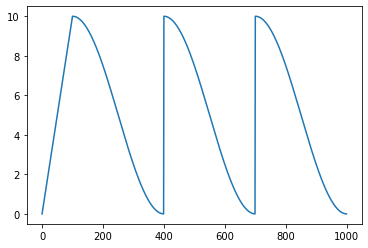

In [11]:
import torch
import matplotlib.pyplot as plt
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=10)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 100, 1_000, 3)
lrs = []

for i in range(1_000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",0.1 if i!=0 and i%2!=0 else 1," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(1_000),lrs)

In [15]:
! conda install cudatoolkit

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/jovyan/conda-envs/giottodeep

  added / updated specs:
    - cudatoolkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py38h578d9bd_1         145 KB  conda-forge
    cudatoolkit-11.1.1         |       h6406543_8        1.20 GB  conda-forge
    ------------------------------------------------------------
                                           Total:        1.20 GB

The following NEW packages will be INSTALLED:

  cudatoolkit        conda-forge/linux-64::cudatoolkit-11.1.1-h6406543_8

The following packages will be UPDATED:

  ca-c

In [6]:
import torch_optimizer as optim

# model = ...
optimizer = optim.Shampoo(
    m.parameters(),
    lr=1e-1,
    momentum=0.0,
    weight_decay=0.0,
    epsilon=1e-4,
    update_freq=1,
)

pandas.core.frame.DataFrame

In [11]:
dataloaders_dicts = DataLoaderKwargs(train_kwargs = {"batch_size":
                                                        config_data.batch_size_train,
                                                    "shuffle":True},
                                     val_kwargs = {"batch_size": 16},
                                     test_kwargs = {"batch_size": 3})

og = OrbitsGenerator(num_orbits_per_class=1_000,
                     homology_dimensions = config_data.homology_dimensions,
                     validation_percentage=0.2,
                     test_percentage=config_data.test_percentage,
                     n_jobs=config_data.num_jobs,
                     dynamical_system = config_data.dynamical_system,
                     dtype=config_data.dtype,
                     arbitrary_precision=False,
                     )
dl_train, dl_val, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)

In [ ]:
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score

class SetTransformerOld(pl.LightningModule):
    """ Vanilla SetTransformer from
    https://github.com/juho-lee/set_transformer/blob/master/main_pointcloud.py
    """
    def __init__(
        self,
        dim_input=4,  # dimension of input data for each element in the set
        num_outputs=1,
        dim_output=5,  # number of classes
        num_inds=32,  # number of induced points, see  Set Transformer paper
        dim_hidden=128,
        num_heads="4",
        layer_norm="False",  # use layer norm
        dropout=0.0,
        num_layer_enc=2,
        num_layer_dec=2,
        activation="nn.Relu()",
        bias_attention=True,
        attention_type="induced_attention"
    ):
        super().__init__()
        if attention_type=="induced_attention":
            self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, eval(num_heads), num_inds, ln=eval(layer_norm), bias_attention=bias_attention),
                *[ISAB(dim_hidden, dim_hidden, eval(num_heads), num_inds, ln=eval(layer_norm), bias_attention=bias_attention)
                  for _ in range(num_layer_enc-1)],
            )
        else:
            self.enc = nn.Sequential(
                SAB(dim_input, dim_hidden, eval(num_heads), ln=eval(layer_norm), bias_attention=bias_attention),
                *[SAB(dim_hidden, dim_hidden, eval(num_heads), ln=eval(layer_norm), bias_attention=bias_attention)
                  for _ in range(num_layer_enc-1)],
            )
        self.dec = nn.Sequential(
            nn.Dropout(dropout),
            PMA(dim_hidden, eval(num_heads), num_outputs, ln=eval(layer_norm), bias_attention=bias_attention),
            nn.Dropout(dropout),
            *[nn.Sequential(nn.Linear(dim_hidden, dim_hidden),
                            nn.ReLU(),
                            nn.Dropout(dropout)) for _ in range(num_layer_dec-1)],
            nn.Linear(dim_hidden, dim_output),
        )
        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input):
        return self.dec(self.enc(input)).squeeze(dim=1)
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x_hat = self.forward(x)
        loss = self.loss_fn(x_hat, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        print(loss)
        return loss
    
    def val_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x_hat = self.forward(x)
        acc = accuracy_score(x_hat, y)
        # Logging to TensorBoard by default
        print("acc", acc)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


model = SetTransformerOld(dim_input=4, dim_output=5,
                       num_inds=config_model.num_induced_points,
                       dim_hidden=config_model.dim_hidden,
                       num_heads=str(config_model.num_heads),
                       layer_norm=str(config_model.layer_norm),  # use layer norm
                       dropout=config_model.dropout_dec,
                       num_layer_enc=config_model.num_layers_encoder,
                       num_layer_dec=config_model.num_layers_decoder,
                       activation=config_model.activation,
                       bias_attention=config_model.bias_attention,
                       attention_type=config_model.attention_type)

trainer = pl.Trainer(max_epochs=100, log_every_n_steps=1, gpus=1)
trainer.fit(model, dl_train)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | enc     | Sequential       | 249 K 
1 | dec     | Sequential       | 83.3 K
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
332 K     Trainable params
0         Non-trainable params
332 K     Total params
1.331     Total estimated model params size (MB)


tensor(1.5949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6709, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5960, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6714, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6398, device='cuda:0', grad_fn=

tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6247, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6224, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6179, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6188, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6090, device='cuda:0', grad_fn=

tensor(1.6020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6188, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6165, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6259, device='cuda:0', grad_fn=

tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6265, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6191, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6060, device='cuda:0', grad_fn=

tensor(1.6107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6192, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6196, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6121, device='cuda:0', grad_fn=

tensor(1.5955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5916, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6156, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6188, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6162, device='cuda:0', grad_fn=

tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=

tensor(1.6107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6191, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=

tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6177, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=

tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6159, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6135, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=

tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=

tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=

tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=

tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6165, device='cuda:0', grad_fn=

tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=

tensor(1.6149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6101, device='cuda:0', grad_fn=

tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6108, device='cuda:0', grad_fn=

tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=

tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6064, device='cuda:0', grad_fn=

tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=

tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=

tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6143, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=

tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6122, device='cuda:0', grad_fn=

tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6127, device='cuda:0', grad_fn=

tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=

tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6133, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6125, device='cuda:0', grad_fn=

tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6126, device='cuda:0', grad_fn=

tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=

tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=

tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6089, device='cuda:0', grad_fn=

tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6180, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6135, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=

tensor(1.6161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6179, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6159, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6026, device='cuda:0', grad_fn=

tensor(1.6128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6252, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6133, device='cuda:0', grad_fn=

tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6133, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6132, device='cuda:0', grad_fn=

tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6103, device='cuda:0', grad_fn=

tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6103, device='cuda:0', grad_fn=

tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=

tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6085, device='cuda:0', grad_fn=

tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=